In [1]:
import torch
import torchvision
import torchvision.datasets
import torchvision.transforms
import torch.utils.data
import torch.nn
import PIL
import pickle
import os
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plot
from PIL import Image
import os
from matplotlib import pyplot as plot

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## 1. Обработка данных

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [98]:
batch_size = 16

In [99]:
class SimpsonsDataset(torch.utils.data.Dataset):
  def __init__(self, files, train, transform):
    super().__init__()
    self.files = files
    self.train = train
    self.transform = transform
    if self.train:
      self.labels = [path.parent.name for path in self.files]
      self.label_encoder = LabelEncoder()
      self.label_encoder.fit(self.labels)
      with open('label_encoder.pkl', 'wb') as le_dump:
        pickle.dump(self.label_encoder, le_dump)

  def __len__(self):
    return len(self.files)

  def __getitem__(self, index):
    path = str(self.files[index])
    image = Image.open(path)
    image = self.transform(image)
    if not self.train:
      return image
    label = self.label_encoder.transform([self.labels[index]]).item()
    return image, label

In [100]:
train_dir = './drive/MyDrive/javaSocketCoridor/simpsons_dataset/'
test_dir = './drive/MyDrive/javaSocketCoridor/kaggle_simpson_testset/'

train_path = sorted(list(Path(train_dir).rglob('*.jpg')))
test_path = sorted(list(Path(test_dir).rglob('*.jpg')))
train_labels = [path.parent.name for path in train_path]

In [101]:
train_files_path, val_files_path = train_test_split(train_path, test_size = 0.15, stratify=train_labels)
test_files_path = test_path

In [102]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [103]:
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean, std),
])

train_dataset = SimpsonsDataset(files=train_files_path, train=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [104]:
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean, std),
])

test_dataset = SimpsonsDataset(files=test_files_path, train=False, transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

val_dataset = SimpsonsDataset(files=val_files_path, train=True, transform=transform_test)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [105]:
classes = set()
for folder in os.listdir(train_dir):
    classes.add(folder)
print(f'Classes of dataset: {classes}')
print("Number of classes:", str(len(classes)))

Classes of dataset: {'mayor_quimby', 'lenny_leonard', 'barney_gumble', 'agnes_skinner', 'moe_szyslak', 'sideshow_mel', 'cletus_spuckler', 'disco_stu', 'sideshow_bob', 'comic_book_guy', 'charles_montgomery_burns', 'otto_mann', 'snake_jailbird', 'principal_skinner', 'troy_mcclure', 'krusty_the_clown', 'abraham_grampa_simpson', 'miss_hoover', 'gil', 'maggie_simpson', 'nelson_muntz', 'selma_bouvier', 'waylon_smithers', 'chief_wiggum', 'lisa_simpson', 'groundskeeper_willie', 'homer_simpson', 'simpsons_dataset', 'rainier_wolfcastle', 'martin_prince', 'bart_simpson', 'fat_tony', 'ralph_wiggum', 'professor_john_frink', 'milhouse_van_houten', 'patty_bouvier', 'ned_flanders', 'apu_nahasapeemapetilon', 'lionel_hutz', 'edna_krabappel', 'kent_brockman', 'carl_carlson', 'marge_simpson'}
Number of classes: 43


Number of train samples: 35594


KeyboardInterrupt: ignored

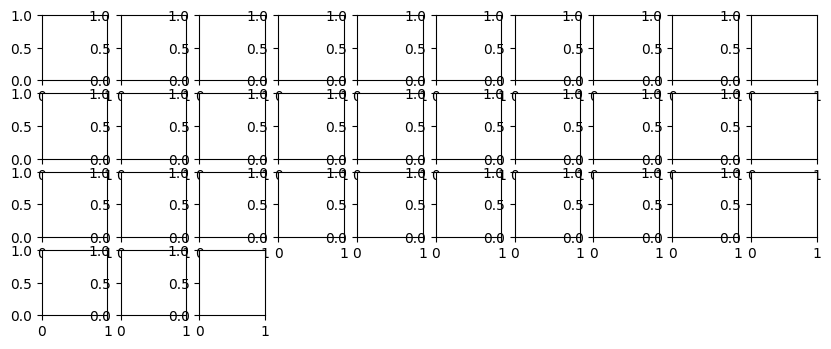

In [106]:
def show_images(images, title):
    num_showed_imgs_x = 10
    num_showed_imgs_y = 10

    figsize = (10, 10)
    fig, axes = plot.subplots(num_showed_imgs_y, num_showed_imgs_x, figsize = figsize)
    fig.suptitle(title)
    plot.setp(plot.gcf().get_axes(), xticks = [], yticks = [])
    for i, ax in enumerate(axes.flat):
        img, label = images[i]
        original_img = images[i][0] * torch.tensor(std).reshape(3, 1, 1) + torch.tensor(mean).reshape(3, 1, 1)
        img = original_img.numpy().transpose(1, 2, 0)
        ax.imshow((img * 255).astype('uint8'))
        img_label = images.label_encoder.inverse_transform([label]).item()
        ax.text(0, 27, str(img_label), color = 'b')

print(f'Number of train samples: {len(train_dataset)}')
show_images(train_dataset, 'Train samples')

In [108]:
def get_shape(dataset):
  n = len(dataset)
  c, h, w = dataset[0][0].numpy().shape
  return [n, *(dataset[0][0].numpy().shape)]

print(f'Shape of input train data: {get_shape(train_dataset)}')
print(f'Data type: {train_dataset[0][0].numpy().dtype}')

Shape of input train data: [35594, 3, 224, 224]
Data type: float32


In [109]:
data_shape = get_shape(train_dataset)
data_shape[0] = 1

## 2. Построение архитектуры сверточной сети

In [110]:
import math

class Bottleneck(torch.nn.Module):
    def __init__(self, in_planes, growth_rate):
        super(Bottleneck, self).__init__()
        self.bn1 = torch.nn.BatchNorm2d(in_planes)
        self.conv1 = torch.nn.Conv2d(in_planes, 4*growth_rate, kernel_size=1, bias=False)
        self.bn2 = torch.nn.BatchNorm2d(4*growth_rate)
        self.conv2 = torch.nn.Conv2d(4*growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(torch.nn.functional.relu(self.bn1(x)))
        out = self.conv2(torch.nn.functional.relu(self.bn2(out)))
        out = torch.cat([out,x], 1)
        return out


class Transition(torch.nn.Module):
    def __init__(self, in_planes, out_planes):
        super(Transition, self).__init__()
        self.bn = torch.nn.BatchNorm2d(in_planes)
        self.conv = torch.nn.Conv2d(in_planes, out_planes, kernel_size=1, bias=False)

    def forward(self, x):
        out = self.conv(torch.nn.functional.relu(self.bn(x)))
        out = torch.nn.functional.avg_pool2d(out, 2)
        return out


class DenseNet(torch.nn.Module):
    def __init__(self, block, nblocks, growth_rate=12, reduction=0.5, num_classes=43):
        super(DenseNet, self).__init__()
        self.growth_rate = growth_rate

        num_planes = 2*growth_rate
        self.conv1 = torch.nn.Conv2d(3, num_planes, kernel_size=3, padding=1, bias=False)

        self.dense1 = self._make_dense_layers(block, num_planes, nblocks[0])
        num_planes += nblocks[0]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans1 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense2 = self._make_dense_layers(block, num_planes, nblocks[1])
        num_planes += nblocks[1]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans2 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense3 = self._make_dense_layers(block, num_planes, nblocks[2])
        num_planes += nblocks[2]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans3 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense4 = self._make_dense_layers(block, num_planes, nblocks[3])
        num_planes += nblocks[3]*growth_rate

        self.bn = torch.nn.BatchNorm2d(num_planes)
        self.linear = torch.nn.Linear(num_planes, num_classes)

    def _make_dense_layers(self, block, in_planes, nblock):
        layers = []
        for i in range(nblock):
            layers.append(block(in_planes, self.growth_rate))
            in_planes += self.growth_rate
        return torch.nn.Sequential(*layers)

    def forward(self, x):
        #print(x.shape)
        out = self.conv1(x)
        #print(out.shape)
        out = self.trans1(self.dense1(out))
        #print(out.shape)
        out = self.trans2(self.dense2(out))
        #print(out.shape)
        out = self.trans3(self.dense3(out))
        #print(out.shape)
        out = self.dense4(out)
        #print(out.shape)
        out = torch.nn.functional.avg_pool2d(torch.nn.functional.relu(self.bn(out)), 28)
        #print(out.shape)
        out = out.view(out.size(0), -1)
        #print(out.shape)
        out = self.linear(out)
        return out

## 3. Обучение сети

In [111]:
def get_accuracy(model, data_loader, device):
    tp = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            n += labels.size(0)
            tp += (predicted == labels).sum()
    return tp / n

In [112]:
import time
from tqdm import tqdm

def train(model, data_loader, epochs, loss_function, optimizer, device):
    for epoch in range(epoches):
        t0 = time.time()
        for images, labels in tqdm(data_loader, total=len(data_loader)):
            images = images.to(device)
            labels = labels.to(device)
            y = model(images)
            loss = loss_function(y, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        t1 = time.time()
        print(f'Epoch[{epoch + 1}]: accuracy = {get_accuracy(model, data_loader, device)}, time = {t1 - t0}')
    #print(f'Test accuracy: {get_accuracy(model, data_loader, device)}')

In [113]:
learning_rate = 0.01
epoches = 20

torch.cuda.empty_cache()

model_dence = DenseNet(Bottleneck, [6,12,24,16], growth_rate=12)
y = model_dence(torch.rand(1,3,224,224))
print(y.shape)
model_dence = model_dence.to(device)

torch.Size([1, 43])


In [44]:
!pip install torchview

torch.Size([1, 3, 224, 224])
torch.Size([1, 24, 224, 224])
torch.Size([1, 48, 112, 112])
torch.Size([1, 96, 56, 56])
torch.Size([1, 192, 28, 28])
torch.Size([1, 384, 28, 28])
torch.Size([1, 384, 1, 1])
torch.Size([1, 384])


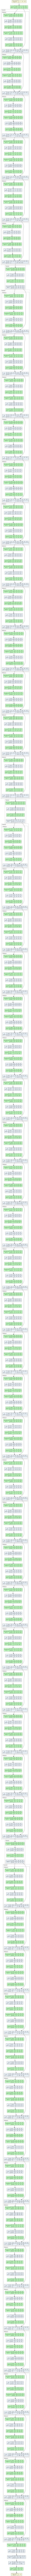

In [28]:
import graphviz
from torchview import draw_graph

graphviz.set_jupyter_format('png')
model_dence.to(device)
model_graph_32x4d = draw_graph(model_dence, input_size=data_shape, expand_nested=True, device=device)
model_graph_32x4d.visual_graph

In [ ]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_dence.parameters(), lr = learning_rate)

train(model_dence, train_loader, epoches, loss_function, optimizer, device)
print(f'Validation accuracy: {get_accuracy(model_dence, test_loader, device)}')

  1%|          | 24/2225 [02:29<3:40:53,  6.02s/it]